# ML-модель для геомаркетинга. В этом ноутбуке показано, как происходили предобработка данных, обучение и тестирование модели.

## Загрузка данных и препроцессинг.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline 
!pip3 install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.5 MB/s eta 0:00:00


## Загрузка данных о расположении магазинов на карте (координаты).

In [ ]:
from openpyxl import load_workbook
from pathlib import Path
import itertools as it


ws = load_workbook(Path('market-coordinates.xlsx'))['Sheet1']
address_to_id = {}
for i, row in it.islice(enumerate(ws.rows), 1, 1000):
    address_to_id[row[1].value] = int(row[0].value)

## Сопоставление адресов и координат.

In [ ]:
ws = load_workbook(Path('filled-table.xlsx'), read_only=True)['Sheet']

market_address_ids = []
market_visitor_frequencies = []

for i, row in it.islice(enumerate(ws.rows), 229):
    address = ' '.join([str(row[i].value) for i in [4, 3, 2]])
    #print(address)
    market_address_ids.append([row[0].value, address_to_id[address]])
    
    visitors = int(row[14].value)
    try:
        days = int(row[15].value)
    except TypeError:
        days = 30
    market_visitor_frequencies.append(visitors / days)

print(market_address_ids)
print(len(market_address_ids))
market_address_ids = np.array(market_address_ids)
market_visitor_frequencies = np.array(market_visitor_frequencies)

[[1, 1], [214, 137], [237, 118], [255, 193], [253, 191], [23, 23], [96, 87], [107, 96], [151, 122], [292, 226], [2, 2], [6, 6], [10, 10], [26, 26], [195, 104], [208, 162], [125, 107], [308, 233], [152, 123], [157, 128], [162, 133], [244, 182], [185, 108], [200, 154], [205, 159], [247, 185], [307, 232], [77, 74], [213, 167], [174, 143], [261, 150], [279, 213], [286, 220], [310, 235], [317, 242], [145, 119], [199, 119], [264, 119], [379, 119], [42, 42], [73, 71], [225, 176], [226, 176], [329, 249], [330, 250], [436, 309], [90, 84], [91, 84], [92, 84], [93, 84], [171, 140], [178, 79], [354, 78], [361, 84], [100, 91], [184, 149], [312, 237], [318, 243], [358, 149], [30, 30], [52, 52], [113, 100], [54, 54], [59, 59], [159, 130], [164, 135], [390, 285], [394, 289], [44, 44], [68, 68], [268, 202], [291, 225], [103, 93], [105, 94], [123, 105], [180, 145], [192, 118], [319, 93], [453, 105], [40, 40], [56, 56], [252, 190], [340, 260], [381, 276], [388, 283], [169, 138], [266, 200], [267, 201], [

## Загрузка основного датасета (информация о площади и посещаемости магазинов).

In [ ]:
main_data = pd.read_csv('./main_data_10.csv')
main_data.head()

,Num,Type,Square,Name,Freqs,Period,Building,FPD
0,1,супермаркет,664,Пятерочка,24 945,28,отдельное здание,"890,8928571"
1,237,магазин,137,Другие,7 417,31,жилой дом,"239,2580645"
2,253,супермаркет,203,Ароматный мир,11 760,31,жилой дом,"379,3548387"
3,23,магазин,216,Другие,6 216,33,жилой дом,"188,3636364"
4,96,магазин,229,Другие,6 002,30,жилой дом,"200,0666667"


### Узнаем размер датасета.

In [ ]:
cntstr = main_data.shape[0]
print(cntstr)

134


### Сопоставление номера магазина в таблице и его уникального ID, к которому привязан адрес.

In [ ]:
id = []
for i in range(cntstr):
  for j in range(229):
    if (main_data['Num'][i] == market_address_ids[j][0]):
      id.append(market_address_ids[j][1])
      break
    j += 1
  i += 1
print(id)
print(len(id))

[1, 118, 191, 23, 87, 122, 2, 6, 10, 26, 107, 233, 128, 133, 182, 108, 159, 185, 232, 167, 220, 235, 242, 119, 42, 176, 249, 250, 309, 84, 84, 84, 140, 79, 91, 237, 243, 30, 100, 54, 59, 44, 68, 202, 94, 145, 105, 56, 260, 283, 138, 200, 201, 216, 229, 109, 111, 126, 257, 258, 270, 168, 318, 117, 155, 304, 117, 37, 69, 188, 5, 12, 73, 268, 206, 147, 275, 115, 91, 221, 222, 224, 152, 152, 161, 89, 269, 61, 58, 67, 101, 114, 151, 114, 27, 43, 203, 120, 251, 297, 3, 98, 94, 137, 219, 36, 183, 256, 277, 192, 291, 38, 196, 234, 204, 34, 252, 265, 266, 148, 85, 232, 112, 280, 281, 284, 290, 298, 300, 230, 85, 306, 315, 150]
134


In [ ]:
main_data.insert(1, 'ID', id)
main_data.head()

,Num,ID,Type,Square,Name,Freqs,Period,Building,FPD
0,1,1,супермаркет,664,Пятерочка,24 945,28,отдельное здание,"890,8928571"
1,237,118,магазин,137,Другие,7 417,31,жилой дом,"239,2580645"
2,253,191,супермаркет,203,Ароматный мир,11 760,31,жилой дом,"379,3548387"
3,23,23,магазин,216,Другие,6 216,33,жилой дом,"188,3636364"
4,96,87,магазин,229,Другие,6 002,30,жилой дом,"200,0666667"


### Считываем информацию о времени в пути от каждого из магазинов до каждого из районов.

In [ ]:
dists = pd.read_csv('./fixed_dist.csv')
dists.head()

,District,Population,Store1,Store2,Store3,Store4,Store5,Store6,Store7,Store8,...,Store309,Store310,Store311,Store312,Store313,Store314,Store315,Store316,Store317,Store318
0,1,646,"28,05127469","40,54699233","39,86133175","29,96589644","29,08400242","35,20199631","32,16069402","30,76793155",...,"37,15582635","12,52727614","31,92653471","8,757369081","20,04190608","3,463823592","15,86386368","31,81204067","22,17310407","22,17310407"
1,2,1562,"24,53101023","36,51983572","38,76202941","25,93873983","26,49269262","33,65528252","28,13353742","26,74077495",...,"36,05652401","18,29523877","37,17121656","10,29062559","23,30607539","8,138245136","17,32035857","37,58000329","23,72590979","23,72590979"
2,3,333,"20,18574414","23,90631289","34,28788331","14,26139268","19,63058031","23,32137173","17,35291896","15,98574574",...,"32,56289287","44,25954175","62,11198903","32,39767337","45,3715918","36,53470906","39,33686203","62,90653109","45,30680316","45,30680316"
3,4,1984,"11,75641437","19,64331217","26,31888014","8,41871025","11,22391948","17,20739571","11,30508437","9,912321898",...,"24,1335631","36,3457885","53,68265926","28,81623836","36,94226203","28,82847446","35,75542701","54,47720132","36,87747339","36,87747339"
4,5,2007,"13,89782815","14,75511342","23,47769306","3,444759625","13,34266433","12,50473867","6,557232515","5,169112684",...,"26,27497689","38,48720229","55,82407304","33,5081258","39,08367582","31,46759986","40,44731446","56,61861511","39,01888717","39,01888717"


### Создадим вспомогательные функции для расчета по формуле Хаффа и обработки ошибок в данных

In [ ]:
def to_flt(s):
  if type(s) != type('help'):
    return s
  s = s.replace(' ', '')
  s = s.replace('\xa0', '')
  s = s.split(',')
  s = '.'.join(s)
  return float(s)

def prob_counter(alp, lamb, i, j): # i - номер района, j - номер магазина (порядковый, не ID !!!)
  sum = 0
  for v in range(cntstr):
    distutil = to_flt((dists[ ('Store' + str(main_data['ID'][v]) )][i - 1]))
    sum += to_flt(main_data['Square'][v])**alp / (distutil if distutil < 25 else distutil/5)**lamb
  distutil = to_flt((dists[ ('Store' + str(main_data['ID'][j - 1]) )][i - 1]))
  return (dists['Population'][i - 1]) * to_flt(main_data['Square'][j - 1])**alp / (distutil if distutil < 25 else distutil/5)**lamb / sum


### Добавляем в основные данные столбец с предполагаемой посещаемостью (по Хаффу).

In [ ]:
main_data.insert(7, 'Huff_predict', list(i for i in range(cntstr)))
main_data.head()

,Num,ID,Type,Square,Name,Freqs,Period,Huff_predict,Building,FPD
0,1,1,супермаркет,664,Пятерочка,24 945,28,0,отдельное здание,"890,8928571"
1,237,118,магазин,137,Другие,7 417,31,1,жилой дом,"239,2580645"
2,253,191,супермаркет,203,Ароматный мир,11 760,31,2,жилой дом,"379,3548387"
3,23,23,магазин,216,Другие,6 216,33,3,жилой дом,"188,3636364"
4,96,87,магазин,229,Другие,6 002,30,4,жилой дом,"200,0666667"


### Создаем функцию для вычисления посещаемости по формуле Хаффа.

In [ ]:
def huff_predict(i, lamb, alp):
  sum = 0
  for j in range(112):
    sum += prob_counter(alp, lamb, j + 1, i + 1)
  return sum

### Разделяем столбцы.

In [ ]:
cat_cols  = ['Type', 'Name', 'Building']
num_cols = ['Square', 'Huff_predict']
target_col = 'FPD'

### Заполняем столбец в основном датасете подсчитанными по формуле Хаффа значениями предполагаемой посещаемости.

In [ ]:
lamb = 0.8
alp = 1
for i in range(cntstr):
  main_data['Huff_predict'][i] = huff_predict(i, lamb, alp)
  main_data['Square'][i] = to_flt(main_data['Square'][i]) 
main_data.head()

### Удаляем лишние столбцы

In [ ]:
X = main_data.drop(target_col, axis = 1)
X = X.drop('Num', axis = 1)
X = X.drop('ID', axis = 1)
#X = X.drop('Square', axis = 1)
X = X.drop('Freqs', axis = 1)
X = X.drop('Period', axis = 1)
#X = X.drop('Building', axis = 1)
#X = X.drop('Type', axis = 1)
X.head()

In [ ]:
Y = main_data[target_col]
for i in range(len(Y)):
  Y[i] = to_flt(Y[i])
Y.head

<ipython-input-249-de7b53776cb9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[i] = to_flt(Y[i])


<bound method NDFrame.head of 0      890.892857
1      239.258064
2      379.354839
3      188.363636
4      200.066667
          ...    
129    473.548387
130    159.241379
131     215.15625
132    223.909091
133    293.033333
Name: FPD, Length: 134, dtype: object>

## Создаем, обучаем и тестируем модель.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import StratifiedKFold

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

gb_proba = CatBoostRegressor(depth = 12, num_trees = 100, learning_rate = 0.5, eval_metric='MAPE')

gb_proba.fit(X_train, Y_train, cat_features=cat_cols)

Y_predict = gb_proba.predict(X)
Y_pred = gb_proba.predict(X_test)
aim = mean_absolute_percentage_error(Y, Y_predict)
print('\nMAPE на всем датасете:', aim)
print('\nMAPE на закрытой тестовой выборке:', mean_absolute_percentage_error(Y_test, Y_pred))

0:	learn: 0.6845997	total: 2.12ms	remaining: 210ms
1:	learn: 0.5471932	total: 3.75ms	remaining: 184ms
2:	learn: 0.4832410	total: 5.76ms	remaining: 186ms
3:	learn: 0.4323959	total: 23.6ms	remaining: 567ms
4:	learn: 0.4154161	total: 24.4ms	remaining: 463ms
5:	learn: 0.3941267	total: 26.6ms	remaining: 416ms
6:	learn: 0.3772921	total: 27.4ms	remaining: 363ms
7:	learn: 0.3762415	total: 28.2ms	remaining: 324ms
8:	learn: 0.3608013	total: 29.5ms	remaining: 298ms
9:	learn: 0.3437597	total: 46.6ms	remaining: 420ms
10:	learn: 0.3343003	total: 49.8ms	remaining: 403ms
11:	learn: 0.3207797	total: 51.8ms	remaining: 380ms
12:	learn: 0.3092289	total: 68.8ms	remaining: 460ms
13:	learn: 0.2933825	total: 87ms	remaining: 535ms
14:	learn: 0.2661541	total: 104ms	remaining: 591ms
15:	learn: 0.2530976	total: 121ms	remaining: 636ms
16:	learn: 0.2419704	total: 138ms	remaining: 676ms
17:	learn: 0.2327199	total: 141ms	remaining: 645ms
18:	learn: 0.2164979	total: 159ms	remaining: 678ms
19:	learn: 0.2073919	total: 1

### Как мы видим, на всём датасете MAPE получилась порядка 25,3%, а на закрытой тестовой выборке и вовсе 23,5%

### Визуализируем результаты прогнозирования на тестовой выборке

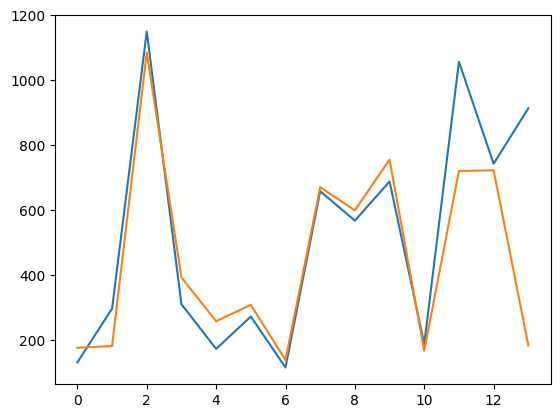

In [ ]:
plt.plot(list(i for i in range(Y_test.shape[0])), Y_test, label = 'real')
plt.plot(list(i for i in range(Y_test.shape[0])), Y_pred, label = 'predicted')

### Визуализируем результаты прогнозирования на всем датасете

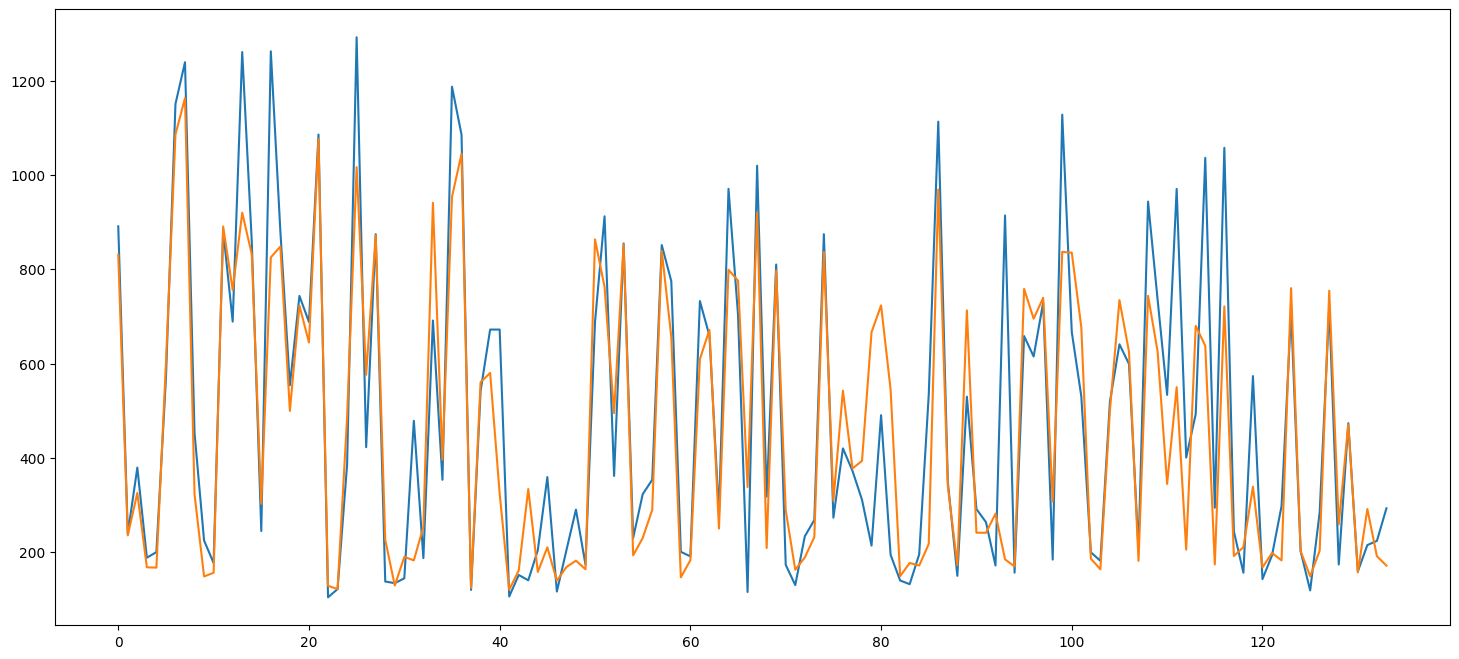

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(list(i for i in range(cntstr)), Y, label = 'real')
plt.plot(list(i for i in range(cntstr)), Y_predict, label = 'predicted')

In [ ]:
X_train.to_csv('./X_train_final.csv')
np.savetxt('./Y_train_final.csv', Y_train)
np.savetxt('./Y_predict_final.csv', Y_predict)